In [10]:
import pyterrier as pt
import pandas as pd
import numpy as np
from pyterrier.measures import RR, nDCG, MAP

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

from common_helpers import *

In [12]:
dataset_path = "irds:beir/fiqa"
dataset = pt.get_dataset(dataset_path)
testset = pt.get_dataset(dataset_path + "/test")
test_queries = testset.get_topics()

In [13]:
# Indexing documents
from pathlib import Path

indexer = pt.IterDictIndexer(
    str(Path.cwd()),  # this will be ignored
    type=pt.index.IndexingType.MEMORY,
)
index_ref = indexer.index(dataset.get_corpus_iter())

beir/fiqa documents: 100%|██████████| 57638/57638 [00:10<00:00, 5350.02it/s]


In [14]:
bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")
dir = pt.terrier.Retriever(index_ref, wmodel="DirichletLM")
pl2 = pt.terrier.Retriever(index_ref, wmodel="PL2")
dfree = pt.terrier.Retriever(index_ref, wmodel="DFReeKLIM")

models = [bm25, dfree, pl2, dir]
metrics = [RR @ 10, nDCG @ 10, MAP @ 100]
noise_levels = np.arange(0.0, 1.1, 0.1)

In [15]:
random_val_per_noise = pd.concat([
        run_noise_experiment(test_queries, testset,
                             nac.OcrAug(aug_char_p=0.25, aug_word_p=noise_level, aug_word_min=0, aug_word_max=500000),
                             models, metrics).assign(noise_level=noise_level)
        for noise_level in noise_levels
    ], ignore_index=True
)
random_val_per_noise["name"] = random_val_per_noise["name"].str.extract(r"TerrierRetr\((.*?)\)")
random_val_per_noise.head(len(models))

20:45:34.505 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:45:44.680 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:45:55.517 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:46:06.105 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found.

,name,RR@10,nDCG@10,AP@100,noise_level
0,BM25,0.310271,0.252589,0.208640,0.0
1,DFReeKLIM,0.315841,0.254521,0.208981,0.0
2,PL2,0.298390,0.241850,0.198975,0.0
3,DirichletLM,0.210783,0.177237,0.143839,0.0


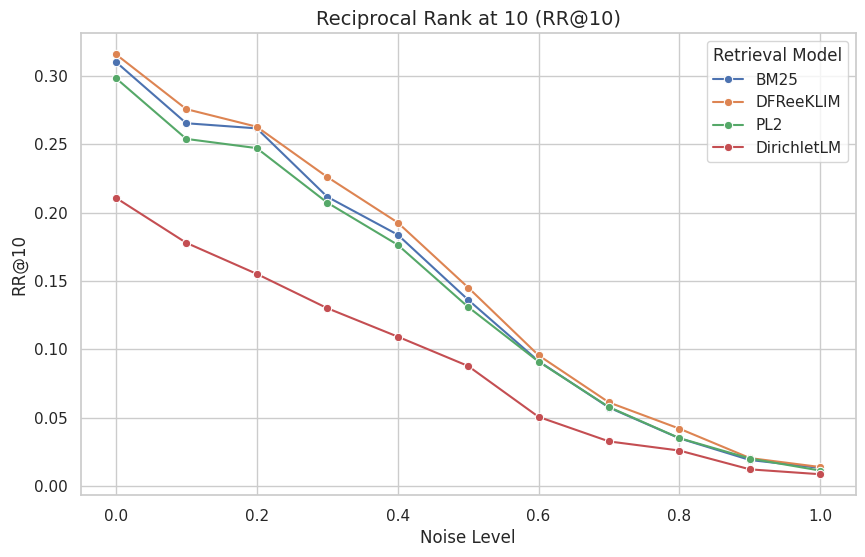

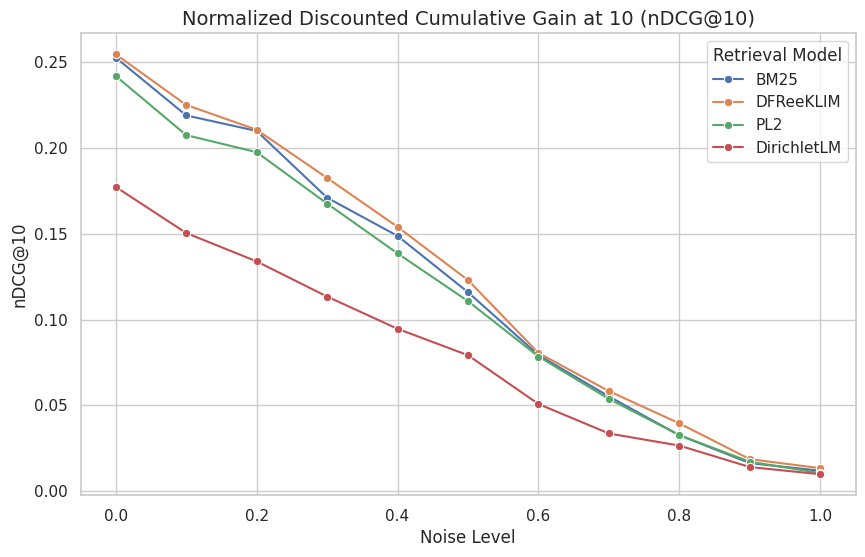

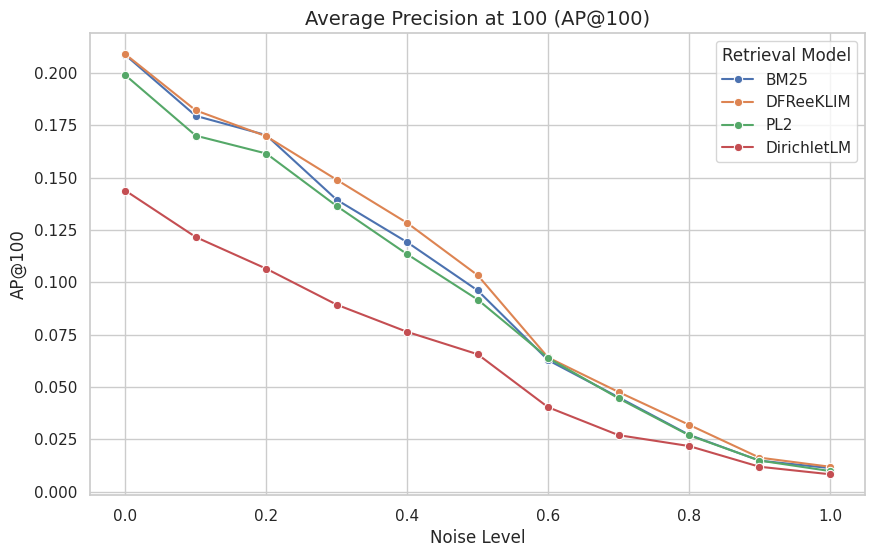

In [16]:
plot_metric(random_val_per_noise, "RR@10", "Reciprocal Rank at 10 (RR@10)", "Retrieval Model")
plot_metric(random_val_per_noise, "nDCG@10", "Normalized Discounted Cumulative Gain at 10 (nDCG@10)", "Retrieval Model")
plot_metric(random_val_per_noise, "AP@100", "Average Precision at 100 (AP@100)", "Retrieval Model")

In [17]:
keyboard_per_noise = pd.concat([
        run_noise_experiment(test_queries, testset, 
                             nac.OcrAug(aug_char_p=0.25, aug_word_p=noise_level, aug_word_min=0, aug_word_max=500000),
                             models, metrics).assign(noise_level=noise_level) 
    for noise_level in noise_levels], ignore_index=True
)
keyboard_per_noise["name"] = keyboard_per_noise["name"].str.extract(r"TerrierRetr\((.*?)\)")
keyboard_per_noise.head(len(models))

,name,RR@10,nDCG@10,AP@100,noise_level
0,BM25,0.310271,0.252589,0.208640,0.0
1,DFReeKLIM,0.315841,0.254521,0.208981,0.0
2,PL2,0.298390,0.241850,0.198975,0.0
3,DirichletLM,0.210783,0.177237,0.143839,0.0


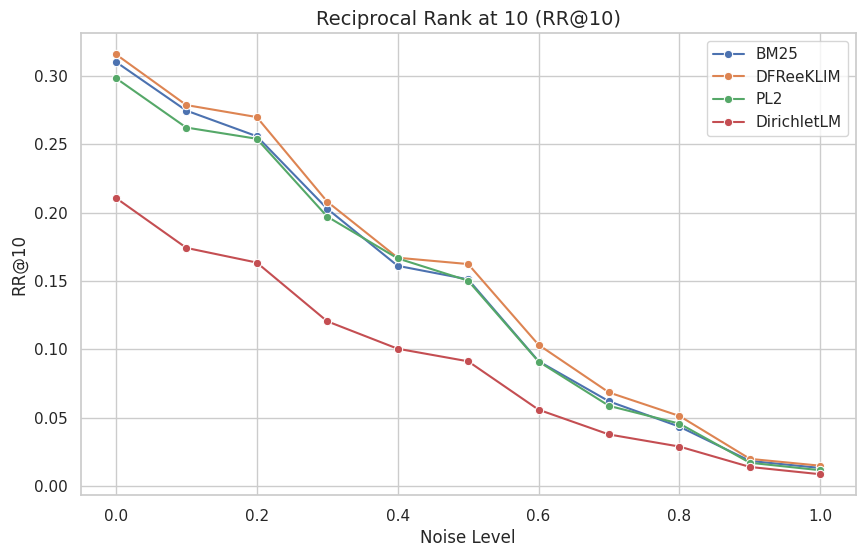

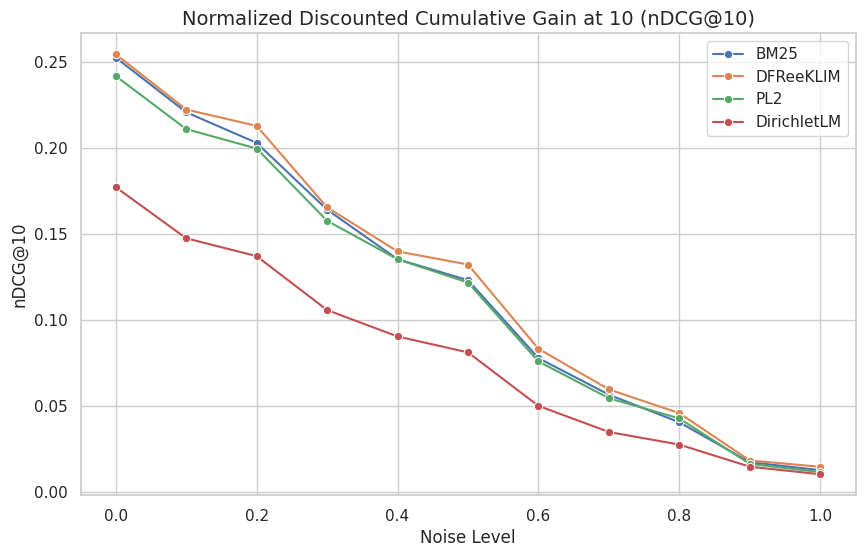

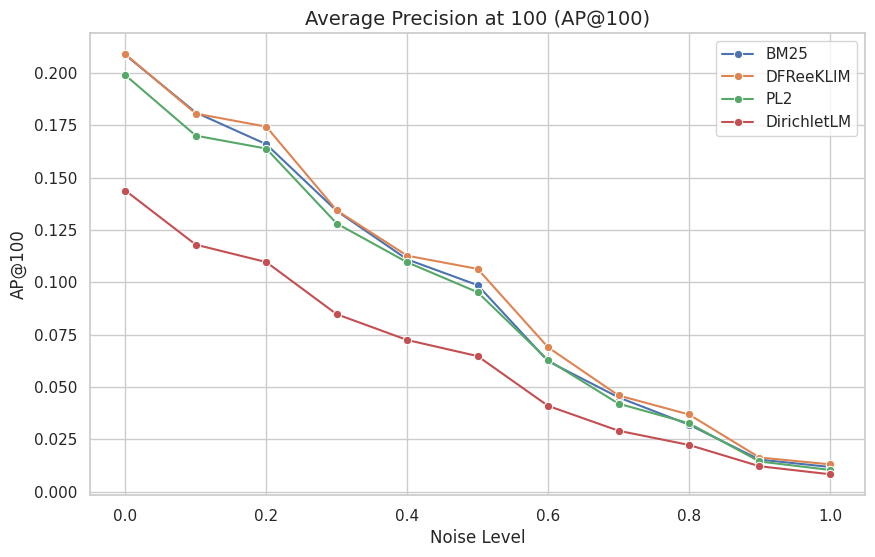

In [18]:
plot_metric(keyboard_per_noise, "RR@10", "Reciprocal Rank at 10 (RR@10)")
plot_metric(keyboard_per_noise, "nDCG@10", "Normalized Discounted Cumulative Gain at 10 (nDCG@10)")
plot_metric(keyboard_per_noise, "AP@100", "Average Precision at 100 (AP@100)")